In [112]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [113]:
# importing libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras


In [114]:
#size of the image
SIZE =224

In [115]:
#loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/sign/sign_data/train",
    image_size=(224, 224)
)

Found 1649 files belonging to 128 classes.


In [116]:
# loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/sign/sign_data/test",
    seed=42,
    image_size=(224, 224)
)

Found 500 files belonging to 42 classes.


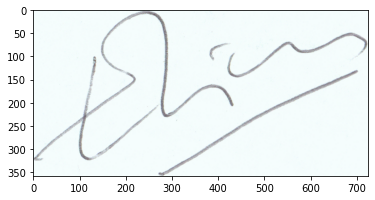

In [117]:
#checking real image
import matplotlib.pyplot as plt
img = plt.imread('/content/gdrive/MyDrive/sign/sign_data/train/001/001_01.PNG')
plt.imshow(img)

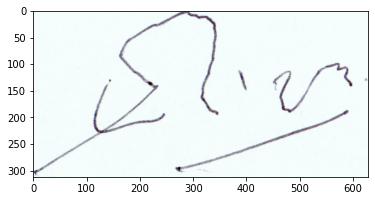

In [118]:
#checking forged image
img1 = plt.imread('/content/gdrive/MyDrive/sign/sign_data/train/001_forg/0119001_01.png')
plt.imshow(img1)

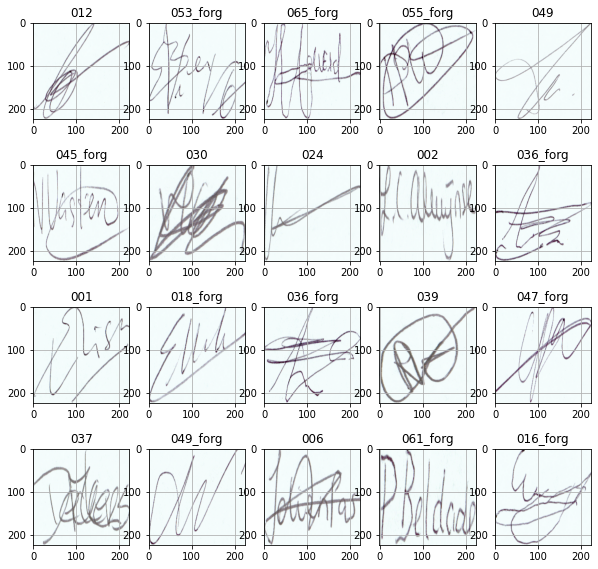

In [119]:
#checking image in training dir
class_names = training_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # print(images[i])
        plt.title(class_names[labels[i]])
        plt.grid(True)

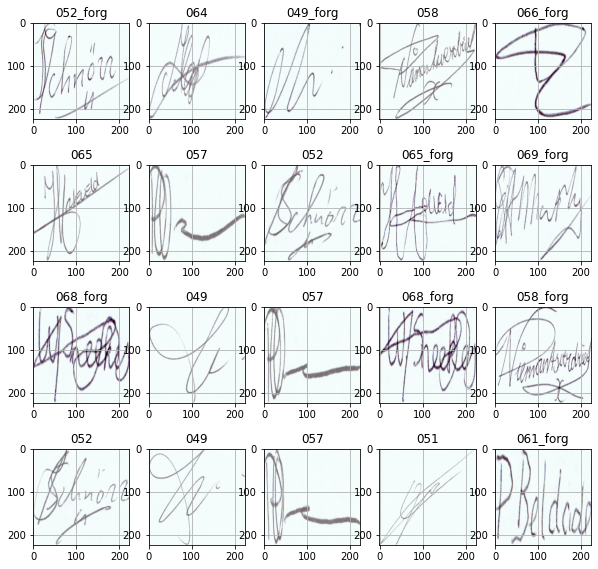

In [120]:
#checking image in testing dir
class_names = testing_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in testing_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # print(images[i])
        plt.title(class_names[labels[i]])
        plt.grid(True)

In [121]:
#saving images in numpy array
import cv2
import os
import glob

train_data = []
train_labels = []

for per in os.listdir("/content/gdrive/MyDrive/sign/sign_data/train/"):
    for data in glob.glob('/content/gdrive/MyDrive/sign/sign_data/train/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        train_data.append([img])
        if per[-1]=='g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))
train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

#Test Data
test_data = []
test_labels = []
for per in os.listdir('/content/gdrive/MyDrive/sign/sign_data/test/'):
    for data in glob.glob('/content/gdrive/MyDrive/sign/sign_data/test/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        test_data.append([img])
        if per[-1]=='g':
            test_labels.append(np.array(1))
        else:
            test_labels.append(np.array(0))
test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)

For use of categorical entropy loss we need to configure data

In [122]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)

In [123]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [124]:
train_data.shape

(1649, 1, 224, 224, 3)

In [125]:
train_data = train_data.reshape(-1, SIZE,SIZE, 3)
test_data = test_data.reshape(-1, SIZE,SIZE, 3)

In [126]:
train_data.shape


(1649, 224, 224, 3)

In [127]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)
test_data,test_labels = shuffle(test_data,test_labels)

importing base model vgg166

In [128]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import Adam

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Here we are freezing first 5 layers of VGG-16 and adding top layers.

In [129]:
i=0
while i != 5:
    base_model.layers[i].trainable = False
    i+=1
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(2, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [130]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
Model Training

In [131]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1)

early_stop=[earlyStopping]

progess = model.fit(train_data,train_labels, batch_size=30,epochs=100, callbacks=early_stop,validation_split=.3)

Epoch 1/100
39/39 [==============================] - 15s 375ms/step - loss: 0.6945 - accuracy: 0.5832 - val_loss: 0.6275 - val_accuracy: 0.6525
Epoch 2/100
39/39 [==============================] - 14s 367ms/step - loss: 0.5420 - accuracy: 0.7348 - val_loss: 0.8895 - val_accuracy: 0.6000
Epoch 3/100
39/39 [==============================] - 14s 367ms/step - loss: 0.2950 - accuracy: 0.8943 - val_loss: 0.4549 - val_accuracy: 0.8020
Epoch 4/100
39/39 [==============================] - 14s 362ms/step - loss: 0.1517 - accuracy: 0.9489 - val_loss: 0.0936 - val_accuracy: 0.9636
Epoch 5/100
39/39 [==============================] - 14s 359ms/step - loss: 0.0629 - accuracy: 0.9731 - val_loss: 0.0707 - val_accuracy: 0.9778
Epoch 6/100
39/39 [==============================] - 14s 359ms/step - loss: 0.1346 - accuracy: 0.9549 - val_loss: 0.1451 - val_accuracy: 0.9374
Epoch 7/100
39/39 [==============================] - 14s 361ms/step - loss: 0.0408 - accuracy: 0.9879 - val_loss: 0.0838 - val_accuracy:

In [149]:
cd /content/gdrive/MyDrive/transfer_learning

/content/gdrive/MyDrive/transfer_learning


In [150]:
model.save("modelvggacc1_val_99_.hdf5")

In [151]:
model.save("modelvggacc99_val_99.h5")

In [1]:
#Accuracy Plots

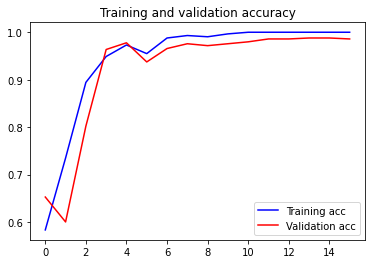

In [134]:
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.show()

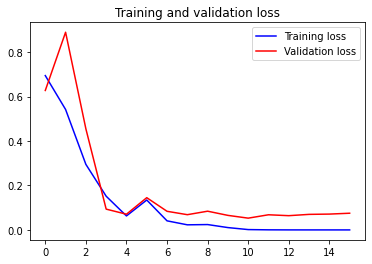

In [135]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [136]:
#prdiction
pred = model.predict(test_data)

16/16 [==============================] - 2s 152ms/step


In [137]:
pred

array([[9.25273638e-13, 1.00000000e+00],
       [7.79328045e-13, 1.00000000e+00],
       [6.39743114e-14, 1.00000000e+00],
       [1.00000000e+00, 1.93323933e-11],
       [4.56394297e-18, 1.00000000e+00],
       [7.18206911e-06, 9.99992847e-01],
       [2.32752065e-21, 1.00000000e+00],
       [4.47407785e-07, 9.99999523e-01],
       [1.00000000e+00, 3.84900911e-09],
       [3.43448889e-14, 1.00000000e+00],
       [1.00000000e+00, 2.78715995e-10],
       [9.99999881e-01, 9.62874580e-08],
       [1.00000000e+00, 3.50667562e-09],
       [1.00000000e+00, 1.71522573e-12],
       [1.00000000e+00, 3.71037210e-08],
       [8.77840383e-15, 1.00000000e+00],
       [1.00000000e+00, 3.56224561e-08],
       [1.00000000e+00, 1.38985907e-08],
       [5.18557700e-16, 1.00000000e+00],
       [9.99999881e-01, 6.77284717e-08],
       [1.00000000e+00, 9.91838833e-10],
       [1.00000000e+00, 1.49816459e-09],
       [2.05326387e-08, 1.00000000e+00],
       [1.00000000e+00, 1.59118130e-09],
       [1.679922

In [138]:
# select the maximum probablity from preds
predict =np.argmax(pred,axis=1)

Confusion Matrix

In [139]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
cm=confusion_matrix(test_labels,predict )
cm

array([[252,   0],
       [  1, 247]])

In [140]:
# True Negatives are denoted by 'TN'
# Actual 'O' values which are classified correctly
TN = cm[0,0]

# True Positives are denoted by 'TP'
# Actual '1' values which are classified correctly
TP = cm[1,1]

# False Positives are denoted by 'FP'
# it is the type 1 error
# Actual 'O' values which are classified wrongly as '1'
FP = cm[0,1]

# False Negatives are denoted by 'FN'
# it is the type 2 error
# Actual '1' values which are classified wrongly as '0'
FN = cm[1,0]

In [141]:
# calculate the precision value
precision = TP / (TP+FP)

# print the value
precision

1.0

In [142]:
recall = TP / (TP+FN)

# print the value
recall

0.9959677419354839

In [143]:
# calculate the specificity value
specificity = TN / (TN+FP)

# print the value
specificity

1.0

In [144]:
# calculate the f1_score
f1_score = 2*((precision*recall)/(precision+recall))

# print the f1_score
f1_score

0.997979797979798

In [145]:
# calculate the accuracy
accuracy = (TN+TP) / (TN+FP+FN+TP)

# print the accuracy
accuracy

0.998

In [2]:
#Classification Report

In [146]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       252
           1       1.00      1.00      1.00       248

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [ ]:
# Cohen Kappa and Roc Auc Score

In [147]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(test_labels,predict)

0.9959996159631325

In [148]:
from sklearn.metrics import roc_auc_score,roc_curve
roc_auc_score(test_labels,predict)

0.997983870967742